**Created on 05/01/2022**

**Group 2**

**Authors: LaurianeBompay**

**License: this code is released under the CeCILL 2.1 license. See
https://www.cecill.info/licenses/Licence_CeCILL_V2.1-en.txt**


In [118]:
import os
import sys
import math
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SequentialFeatureSelector

In [60]:
sns.set_style('darkgrid')

In [61]:
#data importation 
data_1 = pd.read_csv("newData.csv", index_col = 0)
#data_0 = pd.read_csv("positions.csv")

Il faudra changer l'imporation des données quand on aura le jeu de données avec les changements de repaires.

## <center>Remplacement des -inf</center>

In [62]:
data_1.replace([-np.inf], -120, inplace=True)

Les -inf sont dans les rssi et indique que le signal est très mauvais (ce n'est pas un nan) donc on remplace par -120 car c'est la valeur qui indique un mauvais signal (voir la doc sur les rssi)

In [63]:
data_1.describe()

,target,nlos_indicator,t1,t2,t3,t4,skew,tof,tof_skew,range,...,course_dist,temperature_initiator,temperature_target,timestamp,seqnum,rssi_request,rssi_ack,rssi_data,rssi_mean,repaire
count,19730.000000,19730.000000,1.973000e+04,1.973000e+04,1.973000e+04,1.973000e+04,19730.000000,19730.000000,19730.000000,19730.000000,...,19730.000000,19730.000000,19730.000000,1.973000e+04,19730.000000,19730.000000,19730.000000,19730.000000,19730.000000,19730.000000
mean,148.315256,7.215384,5.505930e+11,5.509284e+11,5.510320e+11,5.506966e+11,-2.755970,999.946275,1142.269047,4.690093,...,3.617079,39.577380,39.555326,1.654930e+12,2200.960720,-81.090100,-80.970815,-80.836828,-81.005838,106.200000
std,35.801496,19.474280,3.164088e+11,3.164091e+11,3.164091e+11,3.164088e+11,3.762077,674.275845,646.644922,3.162586,...,2.026579,2.341626,3.781826,3.017622e+05,1216.021329,5.635227,5.072462,4.817778,5.385790,61.171477
min,100.000000,0.000000,6.062043e+07,2.633300e+08,3.679996e+08,1.652910e+08,-11.659438,-613.000000,-152.480214,-2.875181,...,0.000000,30.410000,27.559999,1.654930e+12,1.000000,-120.000000,-120.000000,-120.000000,-120.000000,0.000000
25%,101.000000,2.956454,2.778599e+11,2.782487e+11,2.783513e+11,2.779625e+11,-5.783573,655.000000,715.849019,3.072176,...,1.899738,38.959999,36.680000,1.654930e+12,1174.000000,-79.967224,-79.988684,-79.884079,-79.886929,100.000000
50%,171.000000,3.524929,5.528798e+11,5.532044e+11,5.533074e+11,5.529824e+11,-1.784294,898.000000,998.316717,4.211930,...,3.699628,40.384998,39.340000,1.654930e+12,2231.500000,-79.230034,-79.305238,-79.218111,-79.237715,101.000000
75%,180.000000,4.342597,8.239225e+11,8.243395e+11,8.244432e+11,8.240262e+11,0.338401,1222.000000,1355.550936,5.731602,...,5.399282,41.240002,42.380001,1.654931e+12,3252.000000,-78.659592,-78.701023,-78.666953,-78.686635,150.000000
max,184.000000,342.462982,1.099128e+12,1.099376e+12,1.099479e+12,1.099231e+12,4.829899,2636.000000,2860.190262,12.363750,...,6.999961,42.380001,47.320004,1.654931e+12,4260.000000,-77.162437,-77.516188,-77.428716,-77.478065,180.000000


## <center>Test du modèle random forest pour determiner le position</center>

### Selection des variables pour la prédiction de position

In [109]:
data_for_pred = data_1.drop(['target',
                             'ranging_error',
                             'distance',
                             'timestamp',
                             'course_dist',
                             'temperature_initiator',
                             'temperature_target',
                             'seqnum'],axis=1, inplace=False)

On supprime course_dist car c'est équivalent à la localisation

In [110]:
var = data_for_pred.columns.to_list()
y=data_for_pred[['loc_initiator_x','loc_initiator_y']]

In [111]:
#ceration of test and train
test,train = train_test_split(data_for_pred, test_size=0.3, train_size=0.7, shuffle=True)
Y_train = train[['loc_initiator_x', 'loc_initiator_y']]
X_train = train.drop(["loc_initiator_x",'loc_initiator_y'], axis=1, inplace=False)

Y_test = test[['loc_initiator_x', 'loc_initiator_y']]
X_test = test.drop(["loc_initiator_x",'loc_initiator_y'], axis=1, inplace=False)

In [112]:
X_train.describe()

,nlos_indicator,t1,t2,t3,t4,skew,tof,tof_skew,range,range_skew,loc_target_x,loc_target_y,loc_target_z,rssi_request,rssi_ack,rssi_data,rssi_mean,repaire
count,5919.000000,5.919000e+03,5.919000e+03,5.919000e+03,5.919000e+03,5919.000000,5919.000000,5919.000000,5919.000000,5919.000000,5919.000000,5919.000000,5919.000000,5919.000000,5919.000000,5919.000000,5919.000000,5919.000000
mean,7.143495,5.532821e+11,5.536197e+11,5.537233e+11,5.533857e+11,-2.765811,996.134482,1138.964609,4.672214,5.342137,-0.990476,-0.961939,2.651448,-81.074767,-80.977180,-80.819334,-81.001043,107.015712
std,18.307129,3.194912e+11,3.194882e+11,3.194882e+11,3.194912e+11,3.768767,667.429448,641.020455,3.130474,3.006607,8.111014,4.735312,0.003080,5.655032,5.198641,4.821906,5.453975,61.002027
min,0.000000,6.062043e+07,2.633300e+08,3.679996e+08,1.652910e+08,-11.659438,-613.000000,-152.480214,-2.875181,-0.715185,-15.404000,-9.249000,2.650000,-120.000000,-120.000000,-120.000000,-120.000000,0.000000
25%,2.969840,2.774078e+11,2.776103e+11,2.777147e+11,2.775121e+11,-5.783573,660.000000,722.175906,3.095628,3.387254,-7.359000,-4.671000,2.650000,-79.950134,-79.976960,-79.850138,-79.858307,100.000000
50%,3.533537,5.540527e+11,5.541229e+11,5.542256e+11,5.541571e+11,-1.784294,896.000000,998.478148,4.202549,4.683207,-0.830000,-1.546000,2.650000,-79.215134,-79.290375,-79.214929,-79.232050,101.000000
75%,4.403998,8.325106e+11,8.329515e+11,8.330558e+11,8.326149e+11,0.338401,1217.000000,1340.866141,5.708150,6.289124,5.252000,3.318000,2.650000,-78.651657,-78.695222,-78.667944,-78.677863,150.000000
max,292.917755,1.099128e+12,1.099376e+12,1.099479e+12,1.099231e+12,4.829899,2629.000000,2847.656344,12.330916,13.356490,15.404000,9.249000,2.658000,-77.162437,-77.516188,-77.428716,-77.478065,180.000000


#### Premier modele avec toutes les variables

In [113]:
reg = RandomForestRegressor()
reg = reg.fit(X_train, Y_train)
predic_rf=reg.predict(X_test)

In [114]:
reg.score(X_test,Y_test)

0.9764211695715883

In [115]:
mean_squared_error(Y_test,predic_rf)

0.39439617514732384

In [119]:
mean_absolute_error(Y_test, predic_rf)

0.32666816233437007

#### Affichage de ce premier modele

In [120]:
predic_position = pd.DataFrame(predic_rf, columns=['loc_initiator_x','loc_initiator_y'])

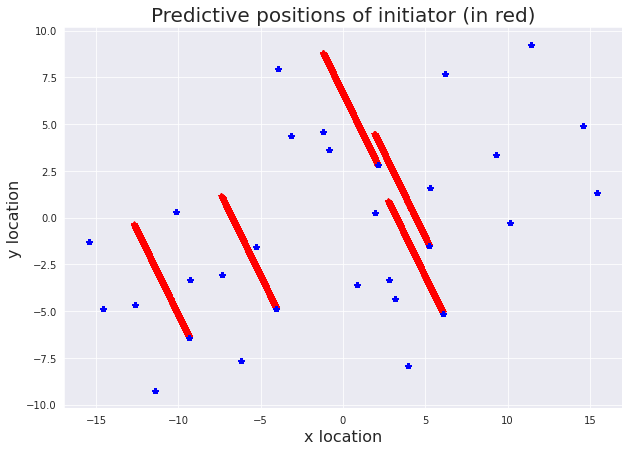

In [121]:
plt.figure(figsize=(10, 7))
plt.plot(predic_position['loc_initiator_x'],predic_position['loc_initiator_y'],'*r')
plt.plot(data_for_pred['loc_target_x'],data_for_pred['loc_target_y'],"*b")
plt.xlabel("x location", fontsize=16)
plt.ylabel("y location", fontsize=16)
plt.title('Predictive positions of initiator (in red)', fontsize=20);

In [122]:
from sklearn.metrics import accuracy_score
list_variable=['nlos_indicator',
 't1',
 't2',
 't3',
 't4',
 'skew',
 'tof',
 'tof_skew',
 'loc_target_x',
 'loc_target_y',
 'rssi_request',
 'rssi_ack',
 'rssi_data',
 'rssi_mean',
 'repaire']
list_variable_tabou=list_variable
variable=[]
score=0
data_for_pred=data_for_pred.sample(frac=1).reset_index(drop=True)
while len(list_variable_tabou)>0:
    y=data_for_pred[['loc_initiator_x','loc_initiator_y']]
    variable_en_cour=False
    for i in list_variable_tabou:
        X=data_for_pred[variable+[i]]
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
        clf = RandomForestRegressor()
        clf= clf.fit(x_train, y_train)
        score_test=clf.score(x_test,y_test)
    if score_test>score:
        score=score_test
        variable_en_cour=i
    if variable_en_cour==False:
        list_variable_tabou=[]
    else:
        variable.append(variable_en_cour)
        del list_variable_tabou[list_variable_tabou.index(variable_en_cour)]
    print(variable_en_cour,score)

repaire 0.8757674543357901
False 0.8757674543357901


Cet algo me dit qu'il faut garder juste repaire mais ça semble faux

In [123]:
reg = RandomForestRegressor()
sfs = SequentialFeatureSelector(reg, direction='forward')
sfs.fit(X_train, Y_train)

SequentialFeatureSelector(estimator=RandomForestRegressor())

In [124]:
var_select = sfs.get_support()
list_variable = X_train.columns.to_list()
for i in range(len(list_variable)) :
    if var_select[i]:
        print(list_variable[i])

nlos_indicator
skew
tof
tof_skew
range
loc_target_x
loc_target_z
rssi_request
rssi_mean


#### Deuxième modèle avec les variables sélectionnées : nlos_indicator, skew, tof, tof_skew, loc_target_y, rssi_data,rssi_mean

In [78]:
#ceration of test and train with selected variables
test,train = train_test_split(data_for_pred[['nlos_indicator',
                                             'skew',
                                             'tof',
                                             'tof_skew',
                                             'loc_target_y',
                                             'rssi_data',
                                             'rssi_ack',
                                             'loc_initiator_x',
                                             'loc_initiator_y']], test_size=0.3, train_size=0.7, shuffle=True)
Y_train = train[['loc_initiator_x', 'loc_initiator_y']]
X_train = train.drop(["loc_initiator_x",'loc_initiator_y'], axis=1, inplace=False)

Y_test = test[['loc_initiator_x', 'loc_initiator_y']]
X_test = test.drop(["loc_initiator_x",'loc_initiator_y'], axis=1, inplace=False)

In [79]:
reg = RandomForestRegressor()
reg = reg.fit(X_train, Y_train)
predic_rf=reg.predict(X_test)
reg.score(X_test,Y_test)

0.9778810323020674

In [80]:
mean_squared_error(Y_test,predic_rf)

0.37186296918390765

In [81]:
predic_position_2 = pd.DataFrame(predic_rf, columns=['loc_initiator_x','loc_initiator_y'])

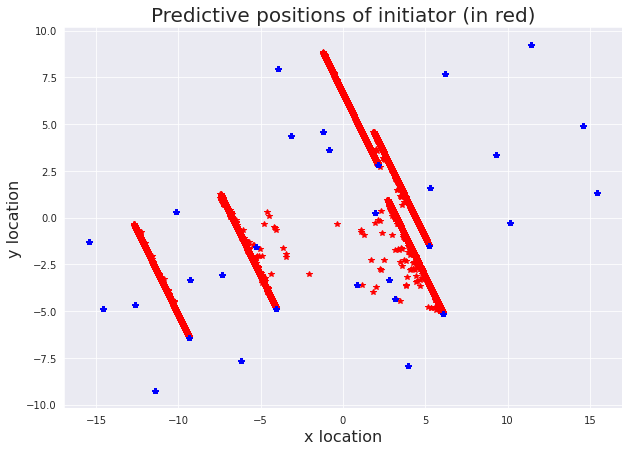

In [82]:
plt.figure(figsize=(10, 7))
plt.plot(predic_position_2['loc_initiator_x'],predic_position_2['loc_initiator_y'],'*r')
plt.plot(data_for_pred['loc_target_x'],data_for_pred['loc_target_y'],"*b")
plt.xlabel("x location", fontsize=16)
plt.ylabel("y location", fontsize=16)
plt.title('Predictive positions of initiator (in red)', fontsize=20);

### Validation croisée

In [83]:
data_for_pred = data_for_pred[['nlos_indicator',
                               't1',
                               't2',
                               't3',
                               't4',
                               'skew',
                                'tof',
                                'tof_skew',
                               'range',
                               'range_skew',
                                'loc_target_y',
                                'rssi_data',
                                'rssi_ack',
                               'rssi_mean',
                               'loc_target_x',
                               'loc_target_z',
                                'loc_initiator_x',
                                'loc_initiator_y']] 

In [84]:
Y = data_for_pred[['loc_initiator_x', 'loc_initiator_y']]
X = data_for_pred.drop(["loc_initiator_x",'loc_initiator_y'], axis=1, inplace=False)

In [85]:
reg = RandomForestRegressor()
cross_val_score(reg, X, Y, cv=5)

array([0.98562565, 0.98404773, 0.98366575, 0.98494453, 0.98470023])

## <center>Affichage du score de RandomForest en fonction des paramètres</center>

#### On va faire varier n_estimators qui correspond au nombre d'arbres de décisions utilisés.

In [86]:
scores_estimators = []

In [87]:
reg_50 = RandomForestRegressor(n_estimators = 1)
reg_50 = reg_50.fit(X_train, Y_train)
scores_estimators.append(reg_50.score(X_test,Y_test))

In [88]:
reg_100 = RandomForestRegressor(n_estimators = 100)
reg = reg_100.fit(X_train, Y_train)
scores_estimators.append(reg_100.score(X_test,Y_test))

In [89]:
reg_150 = RandomForestRegressor(n_estimators = 150)
reg_150 = reg_150.fit(X_train, Y_train)
scores_estimators.append(reg_150.score(X_test,Y_test))

In [90]:
reg_200 = RandomForestRegressor(n_estimators = 200)
reg_200 = reg_200.fit(X_train, Y_train)
scores_estimators.append(reg_200.score(X_test,Y_test))

In [91]:
scores_estimators

[0.9528884887633755, 0.9777691351106388, 0.977946385805198, 0.9778472739539797]

/home/sid2019-6/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Scores with different number of trees')

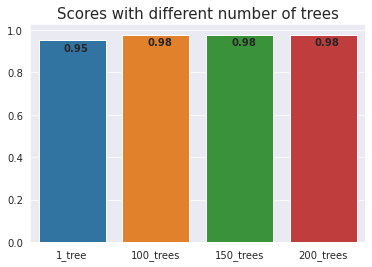

In [92]:
sns.barplot(['1_tree','100_trees','150_trees', '200_trees'],scores_estimators)
plt.text(-0.1, 0.9, round(scores_estimators[0],2), horizontalalignment='left', weight='semibold')
plt.text(0.9, 0.93, round(scores_estimators[1],2), horizontalalignment='left', weight='semibold')
plt.text(1.9, 0.93, round(scores_estimators[2],2), horizontalalignment='left', weight='semibold')
plt.text(2.9, 0.93, round(scores_estimators[3],2), horizontalalignment='left', weight='semibold')
plt.title("Scores with different number of trees",fontsize=15)

À partir de 100 arbres, le score ne change plus. 100 arbres est la valeur par défaut de RandomForest

#### On va faire varier max_depth qui correspond au nombre d'arbres de décisions utilisés.

In [93]:
scores_depth = []

In [94]:
reg_3 = RandomForestRegressor(max_depth = 3)
reg_3 = reg_3.fit(X_train, Y_train)
scores_depth.append(reg_3.score(X_test,Y_test))

In [95]:
reg_15 = RandomForestRegressor(max_depth = 6)
reg_15 = reg_15.fit(X_train, Y_train)
scores_depth.append(reg_15.score(X_test,Y_test))

In [96]:
reg_30 = RandomForestRegressor(max_depth = 9)
reg_30 = reg_30.fit(X_train, Y_train)
scores_depth.append(reg_30.score(X_test,Y_test))

In [97]:
reg_300 = RandomForestRegressor(max_depth = 12)
reg_300 = reg_300.fit(X_train, Y_train)
scores_depth.append(reg_300.score(X_test,Y_test))

/home/sid2019-6/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Scores with different maximum depth')

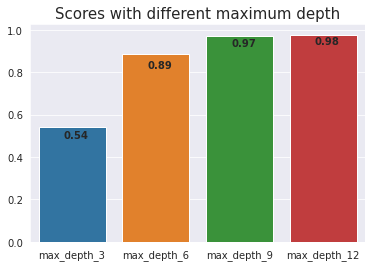

In [98]:
sns.barplot(['max_depth_3','max_depth_6','max_depth_9','max_depth_12'],scores_depth)
plt.text(-0.1, 0.49, round(scores_depth[0],2), horizontalalignment='left', weight='semibold')
plt.text(0.9, 0.82, round(scores_depth[1],2), horizontalalignment='left', weight='semibold')
plt.text(1.9, 0.92, round(scores_depth[2],2), horizontalalignment='left', weight='semibold')
plt.text(2.9, 0.93, round(scores_depth[3],2), horizontalalignment='left', weight='semibold')
plt.title("Scores with different maximum depth",fontsize=15)

#### On va faire varier max_depth et n_estimators en même temps 

In [125]:
list_estimators = [1,100,150,200]
list_depth = [3,6,9,12]

In [126]:
dic_score = {} #{max_depth : n_estimators}
for i in range(len(list_estimators)):
    n_estimator = list_estimators[i]
    list_score = []
    for j in range(len(list_estimators)):
        max_depth = list_depth[j]
        reg = RandomForestRegressor(max_depth = max_depth,n_estimators=n_estimator)
        reg = reg.fit(X_train, Y_train)
        list_score.append(reg.score(X_test,Y_test))
    dic_score[n_estimator]=list_score

In [127]:
dic_score

{1: [0.8809147717299157,
  0.9243453019473076,
  0.9510169702093272,
  0.9569410699774652],
 100: [0.8859360041476576,
  0.9378395701281699,
  0.9675667748784195,
  0.974499230376874],
 150: [0.8857285300181802,
  0.9376451371179864,
  0.9677065548624657,
  0.9750487728441728],
 200: [0.8857875365327351,
  0.938150476172927,
  0.9678001596209262,
  0.9747650110517354]}

/home/sid2019-6/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/sid2019-6/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/sid2019-6/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warn

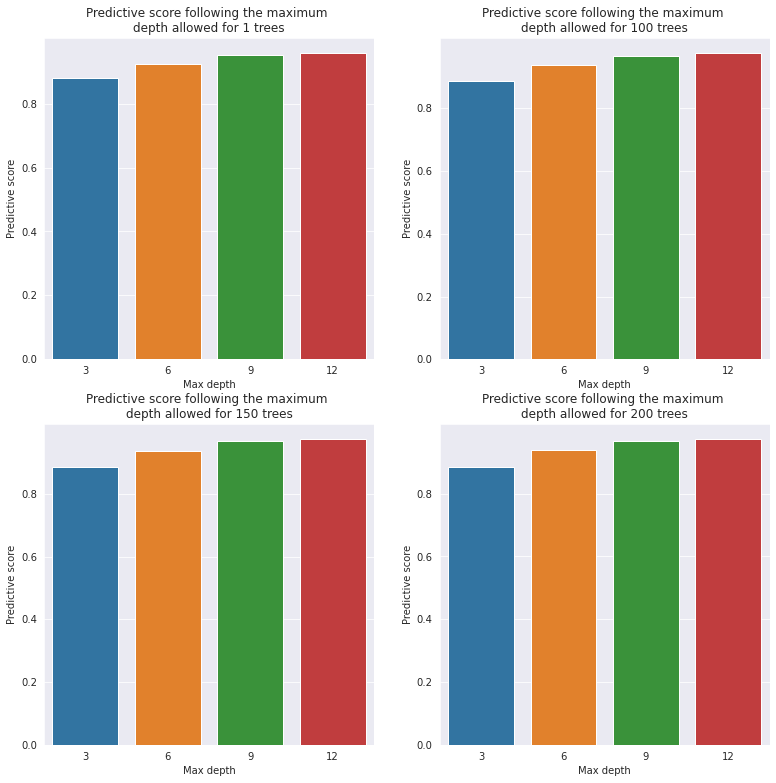

In [128]:
fig = plt.figure(figsize=(13,13))
i=1
for key in dic_score.keys() :
    ax = fig.add_subplot(2,2,i)
    bar1 = sns.barplot(list_depth,
                       dic_score[key])  
    ax.set_xlabel("Max depth")       
    ax.set_ylabel("Predictive score")     
    ax.set_yticks(np.arange(0, 1,0.2))       
    ax.set_title("Predictive score following the maximum \ndepth allowed for "+str(key)+" trees")   
    i+=1

Le maximum de profondeur a un effet sur la prédiction alors que le nombre d'arbre n'a pas beaucoup d'influence. Globalement, on observe la même évolution que ce soit pour 1 arbre ou 200 mais le score augment quand on augmente le maximum de profondeur.

In [129]:
from sklearn.model_selection import GridSearchCV

In [135]:
parameters = {'max_depth':[3,6,9,12,20,30],
              'n_estimators':[1,100,150,200]}
reg = RandomForestRegressor()
clf = GridSearchCV(reg, parameters)
clf.fit(X, Y)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [3, 6, 9, 12, 20, 30],
                         'n_estimators': [1, 100, 150, 200]})

In [137]:
clf.cv_results_

{'mean_fit_time': array([0.01371808, 0.6224185 , 0.91547461, 1.10177298, 0.01304049,
        0.92753081, 1.37320523, 1.83614202, 0.01680655, 1.29532986,
        2.02525859, 2.65650043, 0.02255569, 1.76494532, 2.55366335,
        3.49743414, 0.02877002, 2.49044847, 4.24827471, 5.89526901,
        0.05682549, 3.64597559, 5.17246265, 6.44306087]),
 'std_fit_time': array([1.65228234e-03, 4.28163042e-02, 7.07778959e-02, 7.09610812e-03,
        3.44095863e-04, 6.53408789e-03, 1.18347099e-02, 2.83351916e-02,
        5.67094504e-04, 8.06945253e-03, 6.11572236e-02, 9.07470827e-02,
        5.57799913e-04, 5.37981113e-02, 7.38486546e-02, 8.83298620e-02,
        1.60985521e-03, 1.01116168e-01, 1.61626081e-01, 1.35054876e-01,
        4.70126853e-03, 1.55175903e-01, 4.44227042e-01, 1.78380214e-01]),
 'mean_score_time': array([0.004492  , 0.01712027, 0.02484503, 0.02915688, 0.00351887,
        0.02063646, 0.02895813, 0.03743544, 0.00334311, 0.02705894,
        0.03976731, 0.05162935, 0.00375347, 0.03

In [138]:
clf.cv_results_['params'][clf.best_index_]

{'max_depth': 3, 'n_estimators': 150}